<a href="https://colab.research.google.com/github/caioeserpa/Portifolio/blob/main/C.E.S.A.R/%5BATIVIDADE_FINAL%5D_An%C3%A1lise_de_S%C3%A9ries_Temporais_Caio_Serpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importando bibliotecas

In [ ]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import BaggingRegressor

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 35, 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Criando Funções

In [ ]:
#MA
def show_ma(ts, ma_size):

  to_show = pd.DataFrame()
  to_show['serie'] = ts.values[ma_size:]
  to_show['MA'] = ts.rolling(ma_size).mean().values[ma_size:]
  to_show.plot()
  plt.show()

In [ ]:
def create_windowing(df, lag_size):
  final_df = pd.DataFrame()

  for i in range(0, lag_size+1):
    shifted = df.shift(i)
    if i==0:
      shifted.columns = ['actual']
    else:
      shifted.columns = [f'lag{i}']

    final_df = pd.concat([shifted, final_df], axis=1)

  return final_df.dropna()


In [ ]:
def get_diff(ts, interval=1):
  diff= []

  for i in range(interval, len(ts)):
    value_diff = ts[i] - ts[i-interval]
    diff.append(value_diff)

  return pd.Series(diff)  

## Métricas

In [ ]:

def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf

def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}

In [ ]:
def holdout_val(actual_model, insample, val_size, metric='MSE'):
  X_train = insample[0:-val_size].drop(columns=['actual'])
  y_train = insample[0:-val_size]['actual']

  X_val = insample[-val_size:].drop(columns=['actual'])
  y_val = insample[-val_size:]['actual']

  actual_model.fit(X_train, y_train)

  y_pred = actual_model.predict(X_val)

  X_train_total = insample.drop(columns=['actual'])
  y_train_total = insample['actual']

  actual_model.fit(X_train_total, y_train_total)


  return gerenerate_metric_results(y_val, y_pred)[metric], actual_model

def get_metrics_test(actual_model, out_of_sample, preprocessing, metric='MSE'):
  x_test = out_of_sample.drop(columns=['actual'])
  y_test = out_of_sample['actual'].values

  prev_test = actual_model.predict(x_test)
  prev_test = preprocessing.inverse_transform(prev_test.reshape(-1, 1)).flatten()
  y_test = preprocessing.inverse_transform(y_test.reshape(-1, 1)).flatten()
  return {
      'metric': gerenerate_metric_results(y_test, prev_test)[metric],
      'real': y_test,
      'prev': prev_test
  }

In [ ]:
def holdout_val(actual_model, insample, val_size, metric='MSE'):
  X_train = insample[0:-val_size].drop(columns=['actual'])
  y_train = insample[0:-val_size]['actual']

  X_val = insample[-val_size:].drop(columns=['actual'])
  y_val = insample[-val_size:]['actual']

  actual_model.fit(X_train, y_train)

  y_pred = actual_model.predict(X_val)

  X_train_total = insample.drop(columns=['actual'])
  y_train_total = insample['actual']

  actual_model.fit(X_train_total, y_train_total)


  return gerenerate_metric_results(y_val, y_pred)[metric], actual_model

def get_metrics_test(actual_model, out_of_sample, preprocessing, metric='MSE'):
  x_test = out_of_sample.drop(columns=['actual'])
  y_test = out_of_sample['actual'].values

  prev_test = actual_model.predict(x_test)
  prev_test = preprocessing.inverse_transform(prev_test.reshape(-1, 1)).flatten()
  y_test = preprocessing.inverse_transform(y_test.reshape(-1, 1)).flatten()
  return {
      'metric': gerenerate_metric_results(y_test, prev_test)[metric],
      'real': y_test,
      'prev': prev_test
  }

def dispatch(list_params, forecaster, test_size, val_size, serie):

  result_val = []
  result_test = []
  for params in tqdm(list_params):
    lag_size = params['time_widow']

    model_params = params.copy()

    del model_params['time_widow']

    preprocessing = MinMaxScaler()
    preprocessing.fit(serie[0:-test_size].reshape(-1, 1))
    serie_norm = preprocessing.transform(serie.reshape(-1, 1)).flatten()

    series_lagged = create_windowing(pd.DataFrame({'actual':serie_norm}), lag_size)

    actual_model = clone(forecaster).set_params(**model_params)

    insample = series_lagged.iloc[0:-test_size]
    out_of_sample = series_lagged.iloc[-test_size:]
    val_metric, actual_model = holdout_val(actual_model, insample, val_size)
    result_val.append(val_metric)
    result_test.append(get_metrics_test(actual_model, out_of_sample, preprocessing))


  print(f'MELHORES PARÂMETROS {list_params[np.argmin(result_val)]}')
  print(f'MELHOR VALIDAÇÃO {result_val[np.argmin(result_val)]}')

  return result_test[np.argmin(result_val)]

# ATIVIDADE 1

- pegar duas séries, uma financeira e do imet (transformar em uam série mensal, a máxima);
- análise descritiva: média, o desvio padrão, mínimo, máximo, existem valores ausentes, ou outliers;
- calcular o ACF e PACF das duas séries, existe tendência e/ou sazonalidade?, é random walk?, é um white noise ?
- dado uma série sem_nome, idetificar as características dela, existe tendência e/ou sazonalidade?, é random walk ? é um white noise ?


- pegar duas séries, uma financeira e do imet (transformar em uam série mensal, a máxima);
- análise descritiva: média, o desvio padrão, mínimo, máximo, existem valores ausentes, ou outliers;
- calcular o ACF e PACF das duas séries, existe tendência e/ou sazonalidade?, é random walk?, é um white noise ?
- dado uma série sem_nome, idetificar as características dela, existe tendência e/ou sazonalidade?, é random walk ? é um white noise ?


## Analisando Ações da Petrobras (PETR4.SA)

In [ ]:
ticker_petr4 = yf.Ticker('PETR4.SA')
df_petr4 = ticker_petr4.history(period='max')
df_petr4.to_csv('./petrobras.csv')

In [ ]:
df_petr4

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,2.139587,2.139587,2.139587,2.139587,35389440000,0.0,0.0
2000-01-04,2.021228,2.021228,2.021228,2.021228,28861440000,0.0,0.0
2000-01-05,2.000834,2.000834,2.000834,2.000834,43033600000,0.0,0.0
2000-01-06,1.993914,1.993914,1.993914,1.993914,34055680000,0.0,0.0
2000-01-07,2.003018,2.003018,2.003018,2.003018,20912640000,0.0,0.0
...,...,...,...,...,...,...,...
2022-09-02,34.439999,34.570000,33.259998,33.419998,81792300,0.0,0.0
2022-09-05,33.849998,34.110001,33.150002,33.340000,76337600,0.0,0.0
2022-09-06,32.270000,32.590000,31.510000,32.099998,111813500,0.0,0.0


### Análise de Valores Ausentes

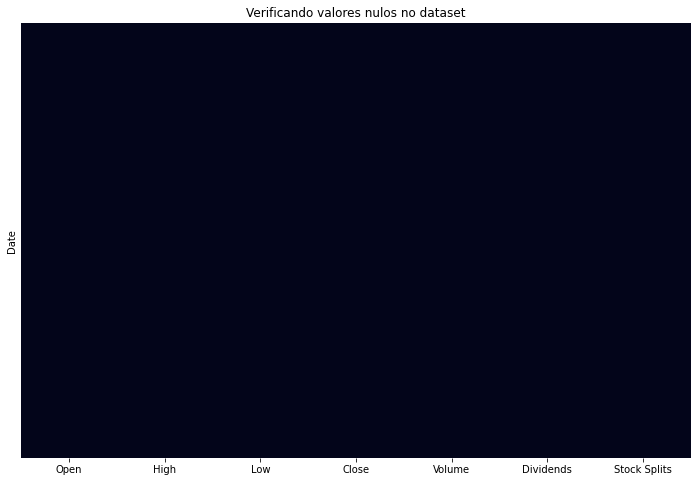



Podemos verificar que no nosso dataset não possui valores ausentes


In [ ]:
plt.figure(figsize=(12,8))

graf = sns.heatmap(df_petr4.isnull(),
                   cbar=False,
                   yticklabels=False);
           
plt.title('Verificando valores nulos no dataset')
plt.show()

print('\n')
print('Podemos verificar que no nosso dataset não possui valores ausentes')

In [ ]:
#média, o desvio padrão, mínimo, máximo, existem valores ausentes, ou outliers;

In [ ]:
df_petr4.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5702.000000,5702.000000,5702.000000,5702.000000,5.702000e+03,5702.000000,5702.000000
mean,8.862245,8.994324,8.720072,8.850980,5.655676e+08,0.004921,0.001052
std,5.255317,5.336903,5.168696,5.251691,3.959096e+09,0.121983,0.059220
min,1.602415,1.620169,1.565996,1.593310,0.000000e+00,0.000000,0.000000
25%,4.257506,4.313657,4.199845,4.255260,2.112185e+07,0.000000,0.000000
50%,8.612221,8.752981,8.502653,8.614981,3.368220e+07,0.000000,0.000000
75%,12.099353,12.287154,11.900428,12.062974,5.425272e+07,0.000000,0.000000
max,34.439999,35.080002,33.450001,34.480000,7.356416e+10,6.732003,4.000000


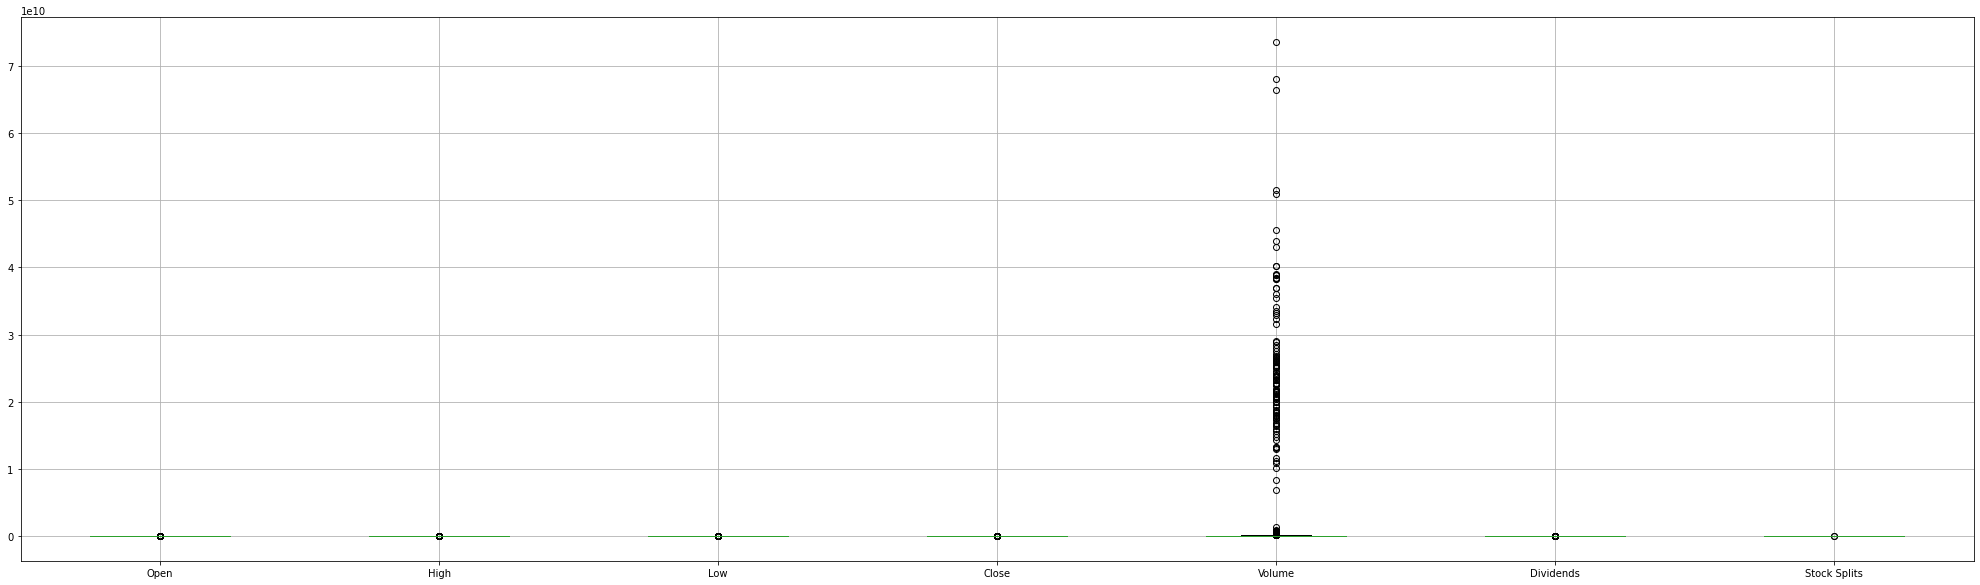

In [ ]:
df_petr4.boxplot();

Analisando o boxplot, podemos verificar que a variável de volume é a que possui mais valores outliers, indicando que em determinadas épocas foram realizadas mais negociações das ações do que em outros momentos

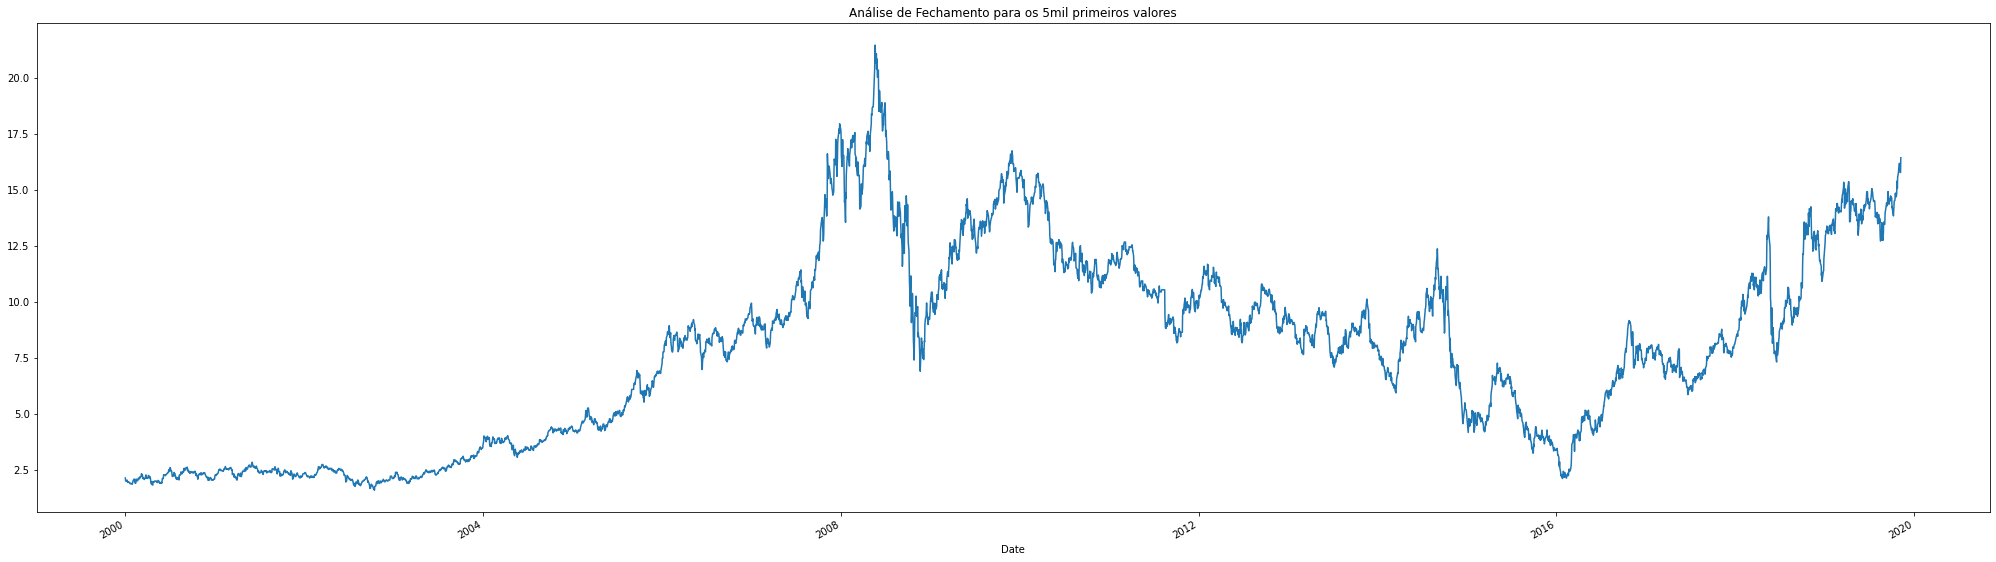

In [ ]:
df_petr4['Close'].iloc[0:5000].plot()

plt.title('Análise de Fechamento para os 5mil primeiros valores')
plt.show()

Podemos verificar que nosso gráfico, mesmo possuindo muitos valores, apresenta uma alguns padrões interessantes, que serão mostrados através da média móvel

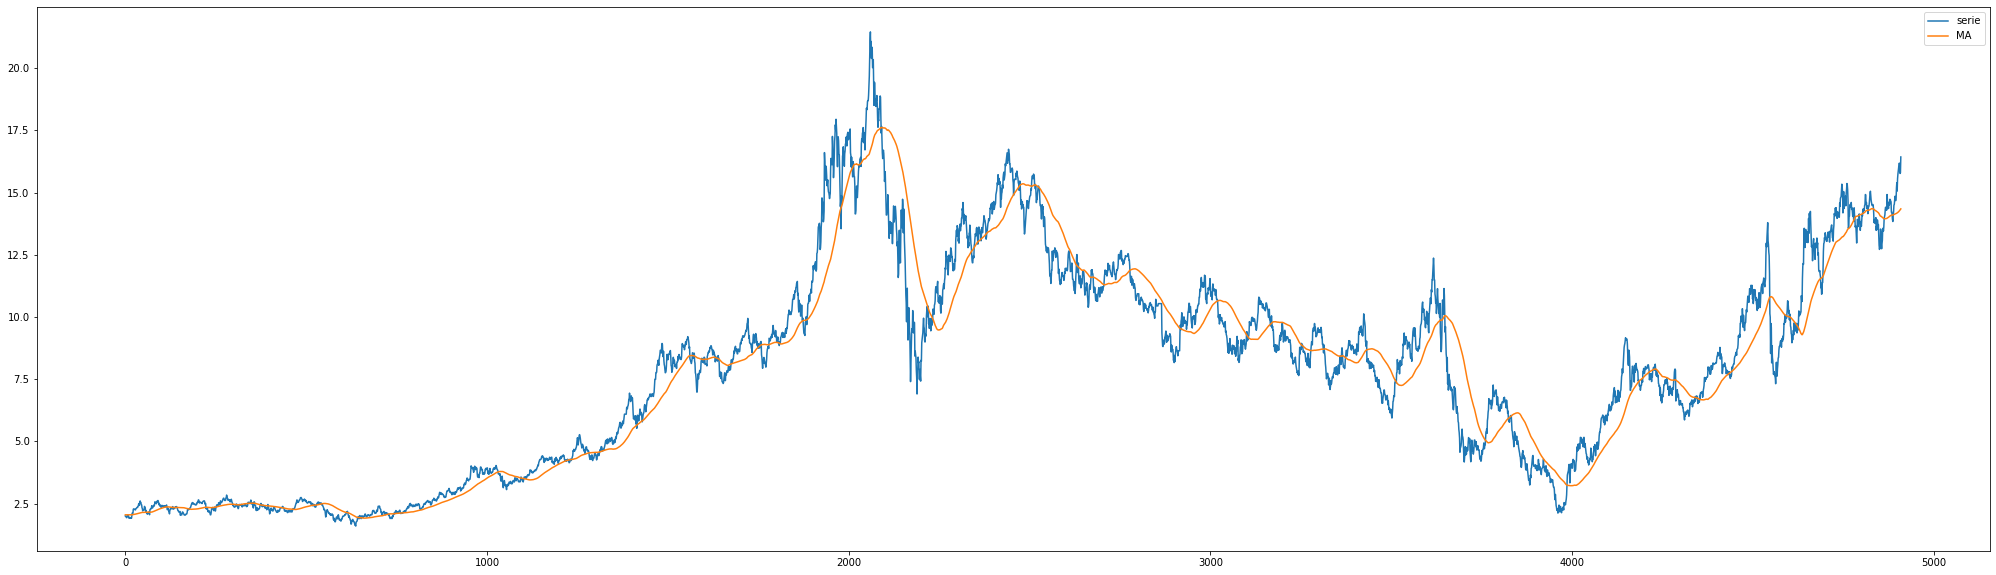

In [ ]:
ts = df_petr4['Close'].iloc[0:5000]
ma_size = 90

show_ma(ts, ma_size)

Com o MA cálculado, podemos verificar que por diversas vezes nossa ação teve um pico de crescimento. Podemos supor que a nossa ação possui uma tendência de crescimento, dao a padrões anteriores apresentados; 

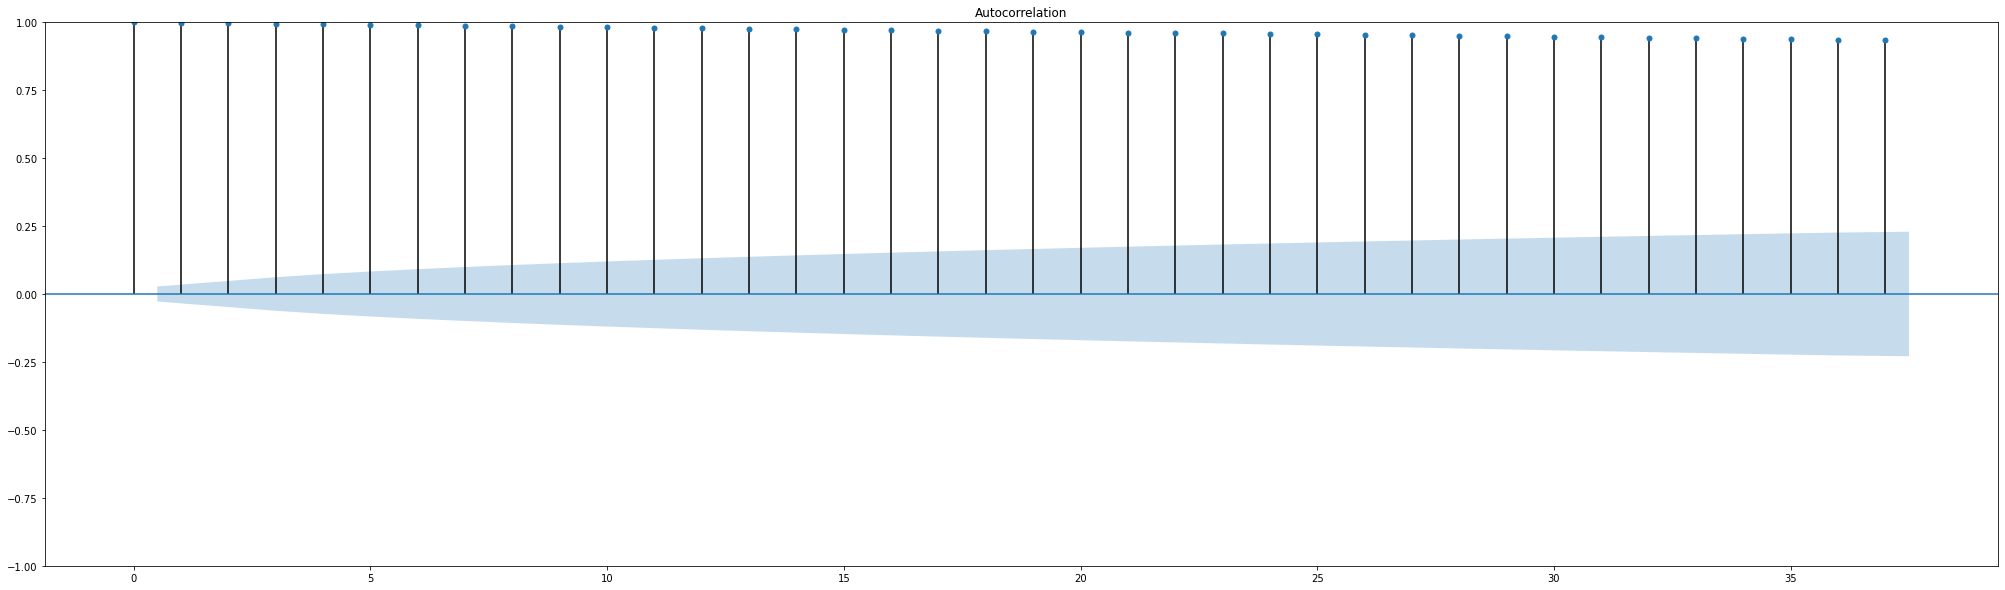

In [ ]:
ts = df_petr4['Close'].iloc[0:5000].values
plot_acf(ts)
plt.show();

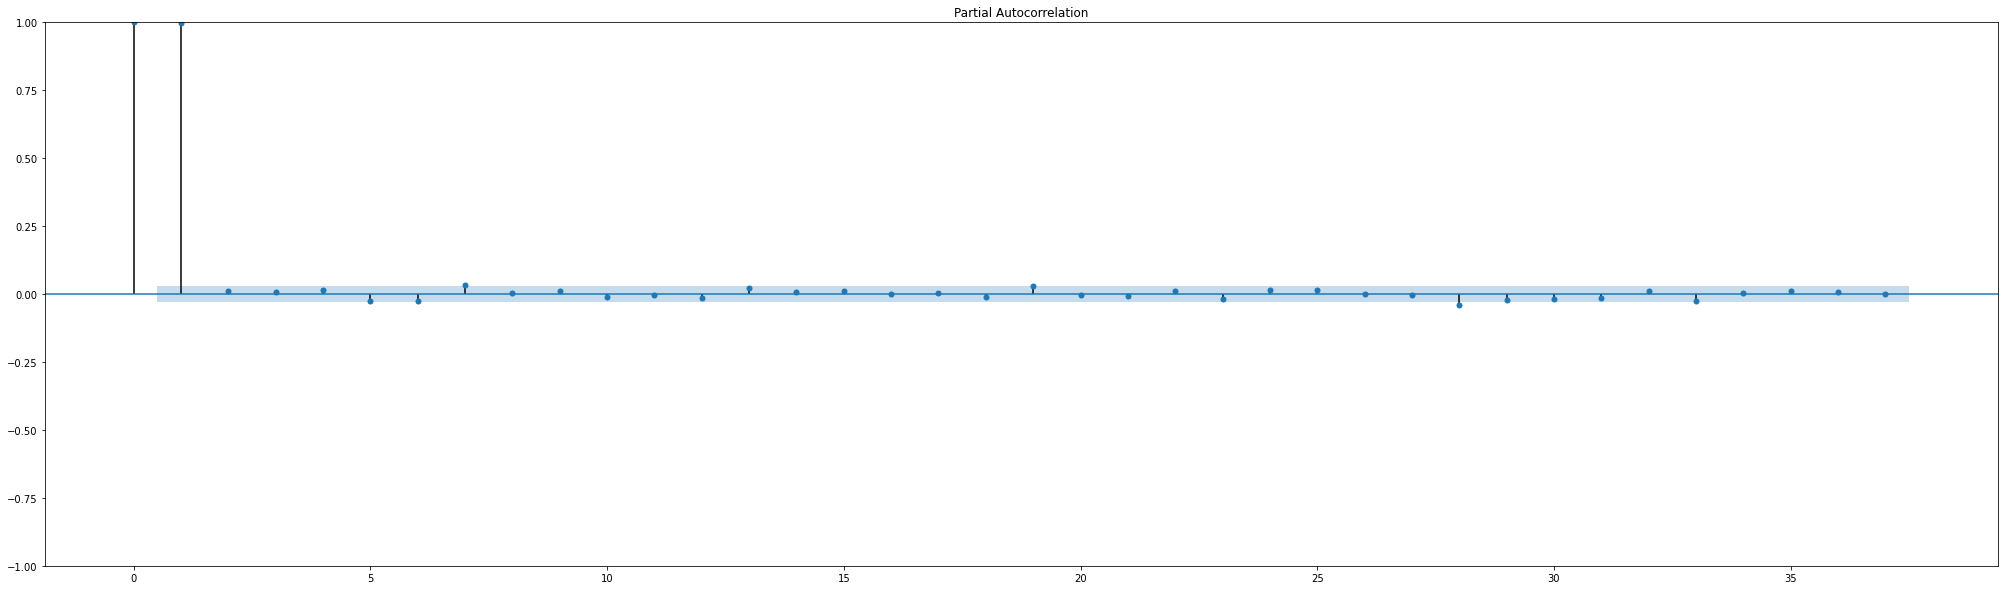

In [ ]:
plot_pacf(ts)
plt.show();

Podemos perceber através do gráfico acima que nossa ação segue o padrão do "andar do bêbado";

Além disso, podemos ver que em determinados momentos o valor ultrapassa a zona de confiança, mostrando que são estatisticamente correlacionadas.

## Gerando Dataset e Análise do Imet

In [ ]:
dates = pd.date_range(start='2014-01-01', end='2022-01-01', freq='Y')
dates_start = dates[0:-1]
dates_end = dates[1:]

In [ ]:
codigo = '82400'
imet_df = []

for init, end in zip(dates_start, dates_end):
  start = init.strftime('%Y-%m-%d')
  end = end.strftime('%Y-%m-%d')

  df =  requests.get(f'https://apitempo.inmet.gov.br/estacao/{start}/{end}/{codigo}').json()
  #https://mapas.inmet.gov.br/

  imet_df.append(pd.DataFrame(df))

In [ ]:
imet_df = pd.concat(imet_df)

In [ ]:
imet_df.head(3)

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_HORA,TEMP_HORA,INSO_HORA,NEBU_HORA,TEMP_MED,CHUVA,VENT_VEL,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,PRESS_EST,VENT_DIR,CD_ESTACAO,VL_LONGITUDE,HR_MEDICAO
0,None,2014-12-31,FERNANDO DE NORONHA,None,None,None,None,None,None,None,-3.85,None,None,PE,None,None,82400,-32.42,0000
1,None,2014-12-31,FERNANDO DE NORONHA,86,24.8,None,None,None,None,6,-3.85,None,None,PE,1007.2,120,82400,-32.42,0600
2,None,2014-12-31,FERNANDO DE NORONHA,70,28.2,None,8.8,None,0,11,-3.85,24.8,None,PE,1007.7,120,82400,-32.42,1200


In [ ]:
noronha_df = imet_df[['DT_MEDICAO', 'HR_MEDICAO', 'TEMP_HORA']]

In [ ]:
noronha_df.TEMP_HORA.isna().value_counts()

False    6128
True     4128
Name: TEMP_HORA, dtype: int64

In [ ]:
noronha_df.loc[(noronha_df['TEMP_HORA'].isnull() == True)] = 0 #criando coluna nova, se a hora for igual a 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
noronha_df.TEMP_HORA.isna().value_counts()

False    10256
Name: TEMP_HORA, dtype: int64

In [ ]:
noronha_df['TEMP_HORA'] = noronha_df['TEMP_HORA'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


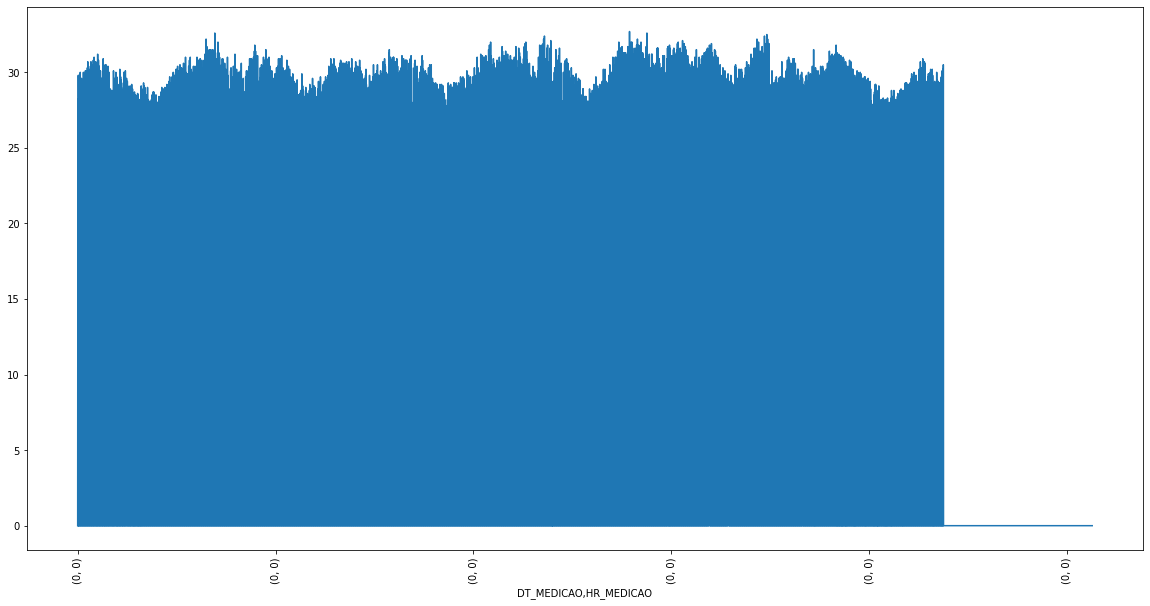

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
noronha_df.set_index(['DT_MEDICAO','HR_MEDICAO'])['TEMP_HORA'].plot(rot=90)

In [ ]:
noronha_df = noronha_df.set_index(['DT_MEDICAO', 'HR_MEDICAO']).iloc[0:3000]

In [ ]:
noronha_df.head(50)

TEMP_HORA
DT_MEDICAO HR_MEDICAO           
0          0                 0.0
2014-12-31 0600             24.8
           1200             28.2
           1800             26.3
0          0                 0.0
2015-01-01 0600             24.8
           1200             29.8
           1800             26.7
0          0                 0.0
2015-01-02 0600             23.1
           1200             28.0
           1800             26.2
0          0                 0.0
2015-01-03 0600             24.8
           1200             29.8
           1800             26.4
0          0                 0.0
2015-01-04 0600             24.7
           1200             29.0
           1800             25.9
0          0                 0.0
2015-01-05 0600             25.5
           1200             29.2
           1800             26.7
0          0                 0.0
2015-01-06 0600             25.5
           1200             30.0
           1800             26.8
0          0                 0.0
2015-01-07 0600             24.9
           1200             29.6
           1800             26.5
0          0                 0.0
2015-01-08 0600             25.2
           1200             29.4
           1800             26.7
0          0                 0.0
2015-01-09 0600             25.5
           1200             29.6
           1800             26.9
0          0                 0.0
2015-01-10 0600             25.3
           1200             29.4
           1800             26.7
0          0                 0.0
2015-01-11 0600             25.4
           1200             29.4
           1800             27.0
0          0                 0.0
2015-01-12 0600             25.7

In [ ]:
noronha_df = noronha_df.reset_index()[['DT_MEDICAO', 'TEMP_HORA']].groupby('DT_MEDICAO').max()

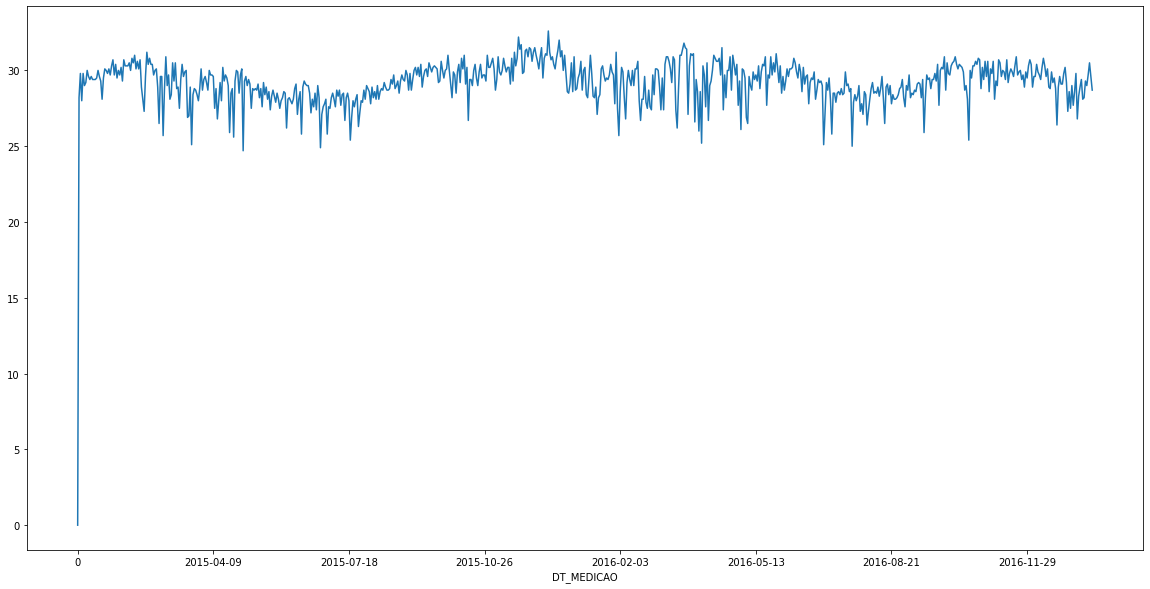

In [ ]:
noronha_df['TEMP_HORA'].plot()

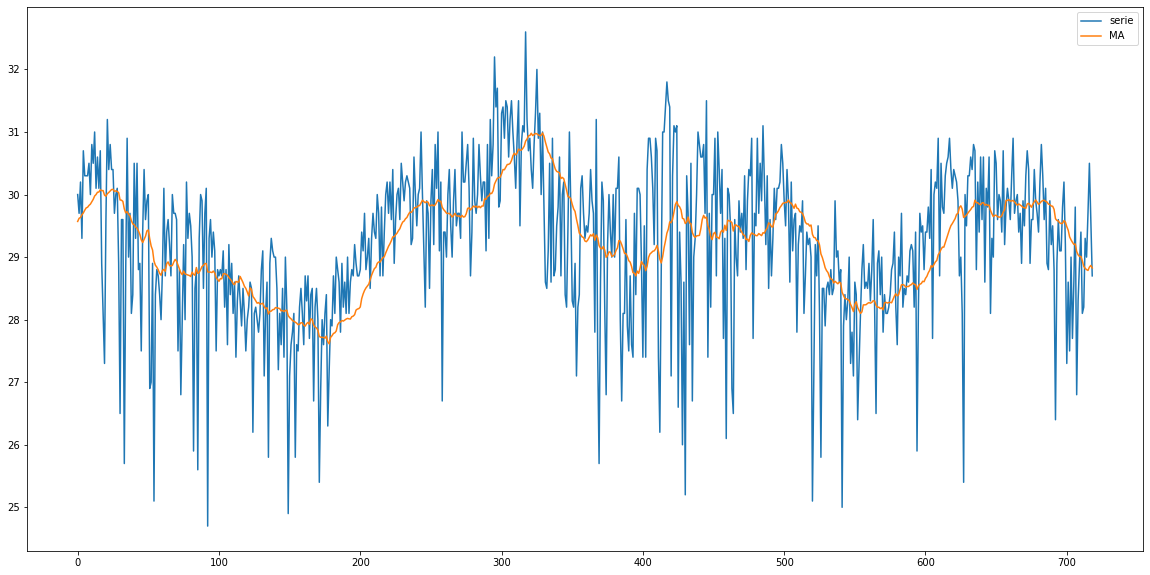

In [ ]:
ts = noronha_df['TEMP_HORA']
ma_size = 30
show_ma(ts, ma_size)

Como podemos analisar, Ferando de Noronha segue um padrão de white noise. 

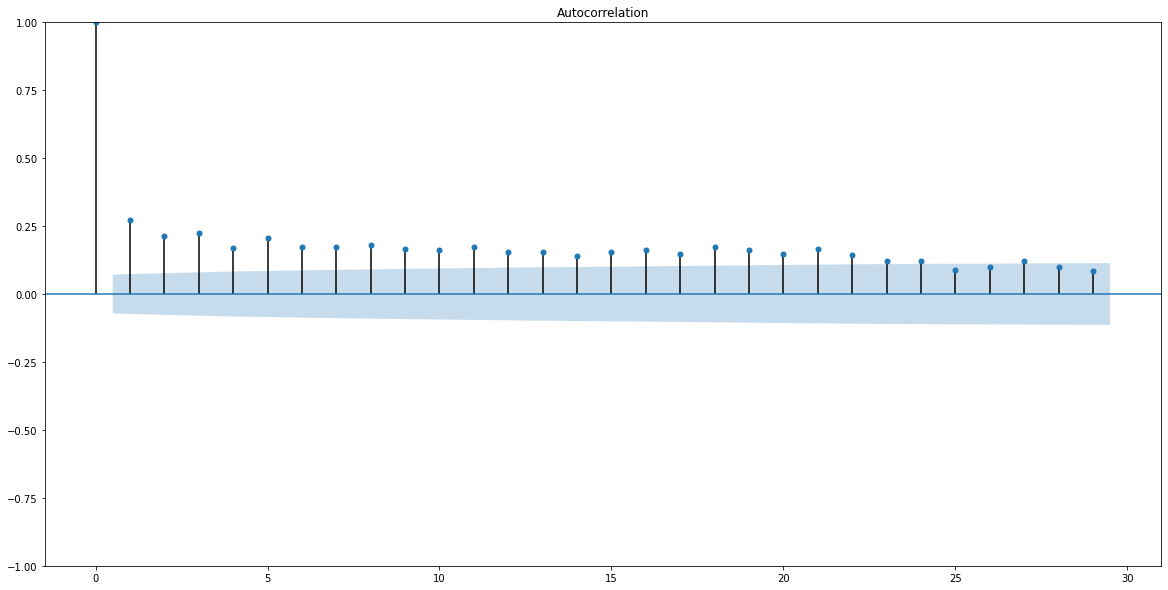

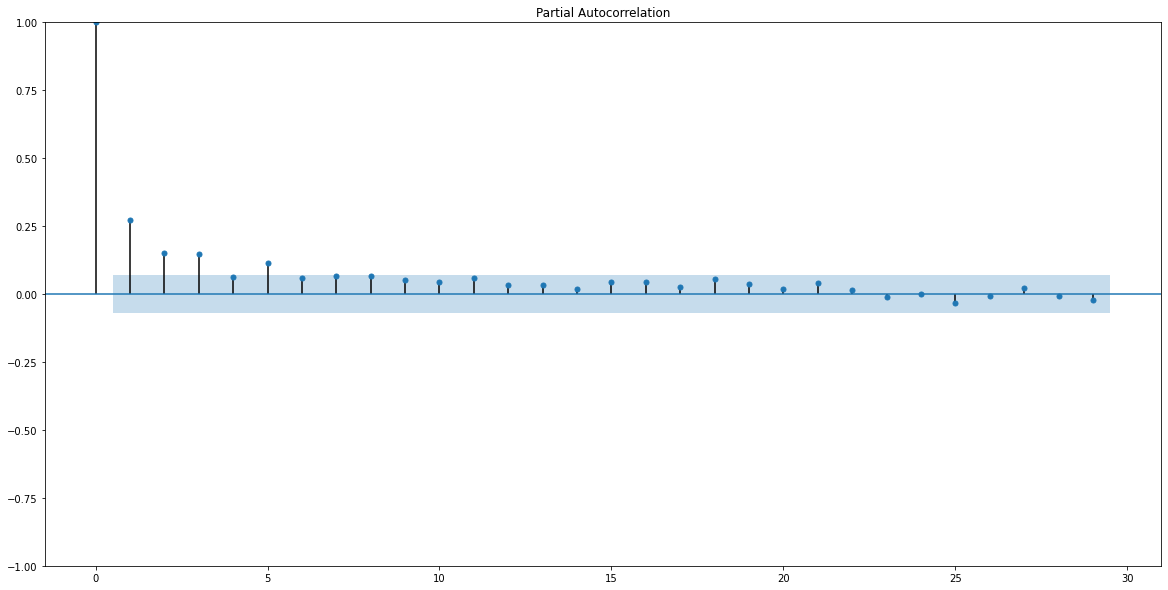

In [ ]:
plot_acf(noronha_df['TEMP_HORA'].values)
plt.show()
plot_pacf(noronha_df['TEMP_HORA'].values)
plt.show()

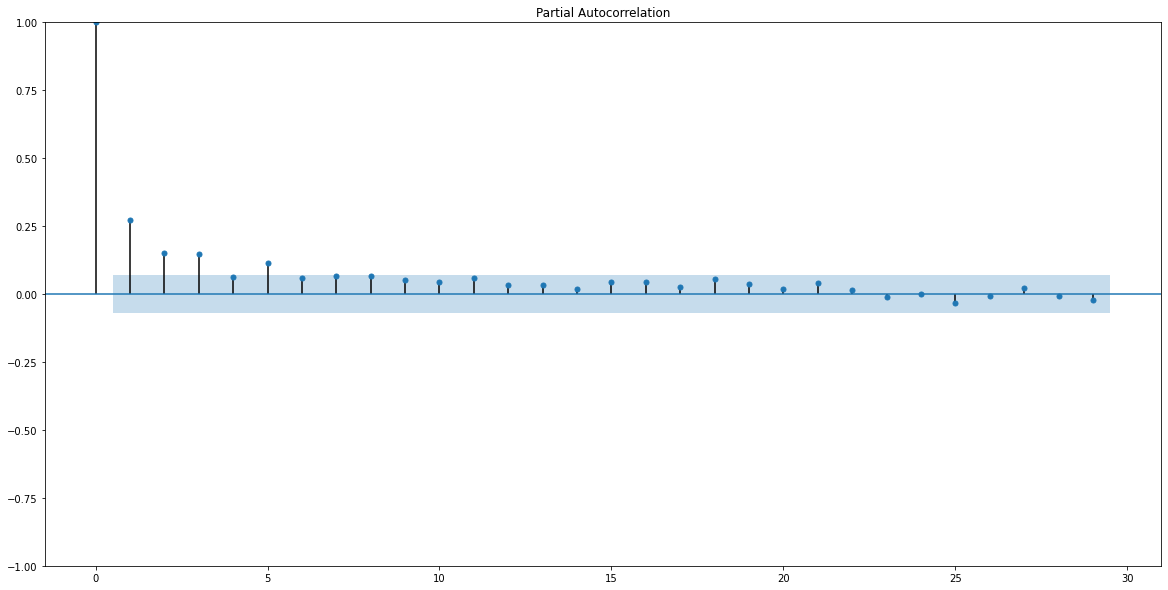

In [ ]:
plot_pacf(noronha_df['TEMP_HORA'].values)
plt.show()

##  Análise da Série "sem_nome"

In [ ]:
sem_nome_df = pd.read_csv('/content/drive/MyDrive/sem_nome.csv')
sem_nome_df

,Unnamed: 0,actual
0,0,-0.852753
1,1,-1.703346
2,2,-0.451841
3,3,0.392410
4,4,0.498923
...,...,...
995,995,-1.343438
996,996,0.199716
997,997,0.639731
998,998,1.013807


In [ ]:
sem_nome_df = pd.read_csv('/content/drive/MyDrive/sem_nome.csv', index_col = 'Unnamed: 0')
sem_nome_df

,actual
0,-0.852753
1,-1.703346
2,-0.451841
3,0.392410
4,0.498923
...,...
995,-1.343438
996,0.199716
997,0.639731
998,1.013807


### plot MA de 30 dias

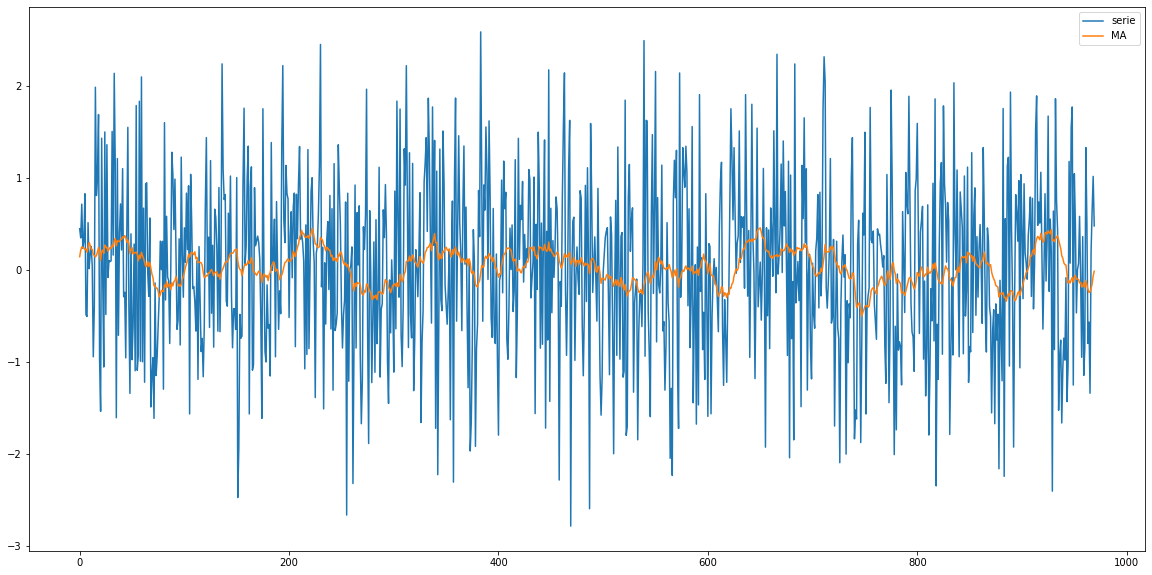

In [ ]:
ma_size = 30
show_ma(sem_nome_df['actual'], ma_size)

Ao analisar nossos dados podemos ver que os dados, em série temporal possuem o padrão de white noise, porém, ao analisarmos o MA, verremos que há períodos onde nossos dados possuem padrões de alta e de baixa, dando uma previsibilidade do que poderá acontecer

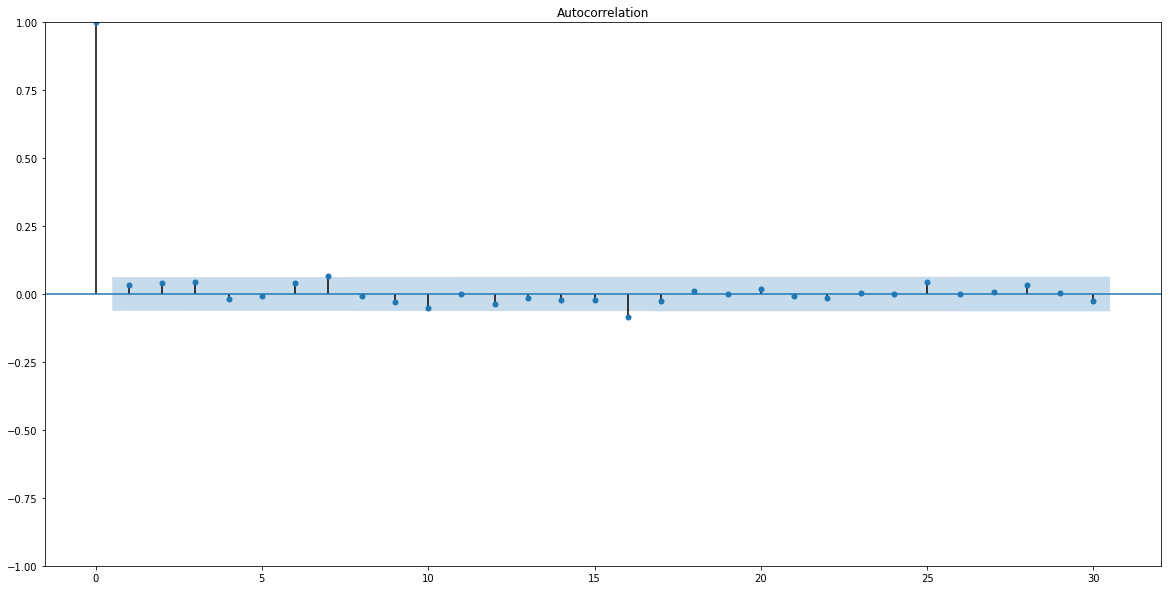

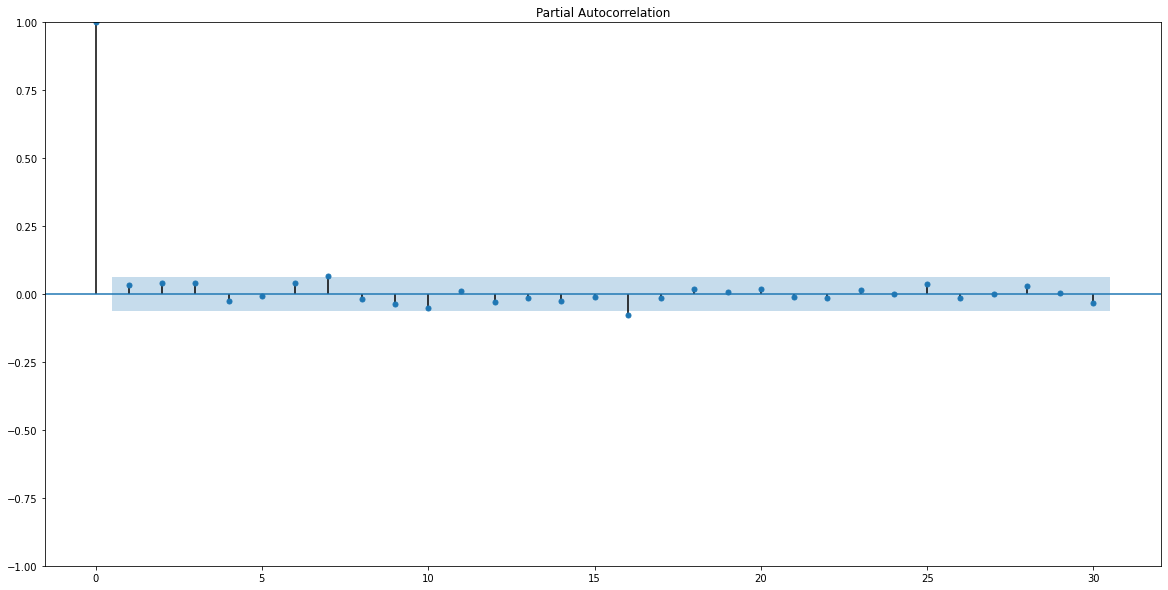

In [ ]:
plot_acf(sem_nome_df)
plt.show()
plot_pacf(sem_nome_df)
plt.show()

Além disso, quando plotamos o PACF e ACF verificamos que também segue o padrão do andar do bêbado

# Atividade 2

- executar o auto.arima para as duas séries estudadas;
- aplicar modelos de machine learning (ML) utilizando as janelas temporais;
- separar os últimos 10% da série para teste;
- comparar as abordagens: ARIMA multi-step, ARIMA one-step, e Modelo de ML;
- avaliar através pelo mean_square_error, mean_absolute_percentage_error e mais uma à sua escolha;

# Calculando KPSS para nossas séries temporais

In [ ]:
kpss_test = KPSSTest()

### Calculando KPSS para série da Petrobrás

(0.01, True)
------------------------------


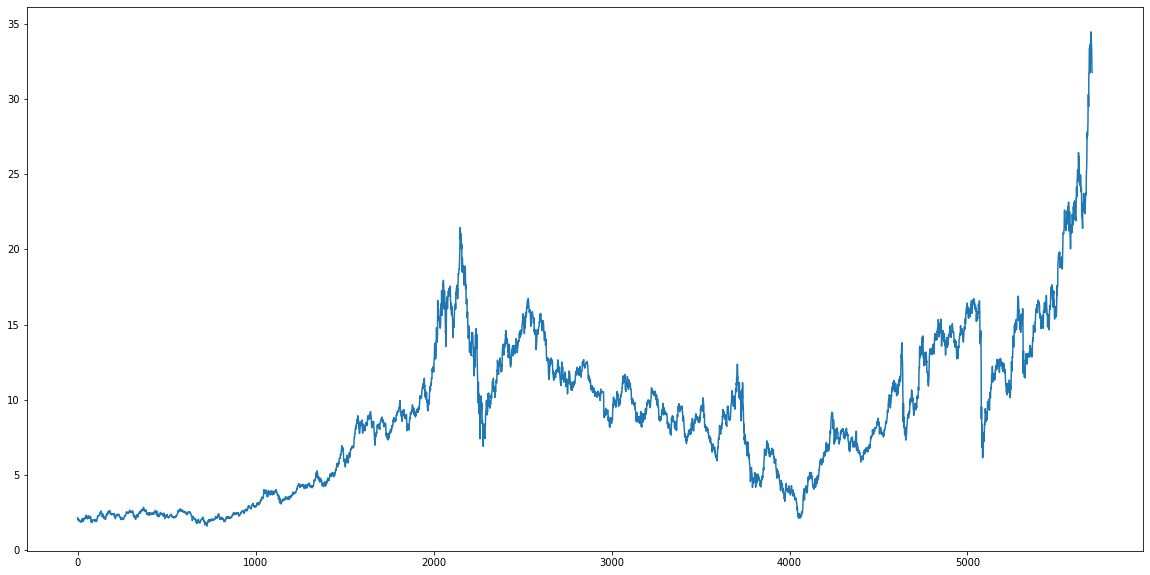

In [ ]:
ts = df_petr4['Close'].interpolate().values
print(kpss_test.should_diff(ts))
print('-'*30)
pd.Series(ts).plot()

(0.01, True)
------------------------------


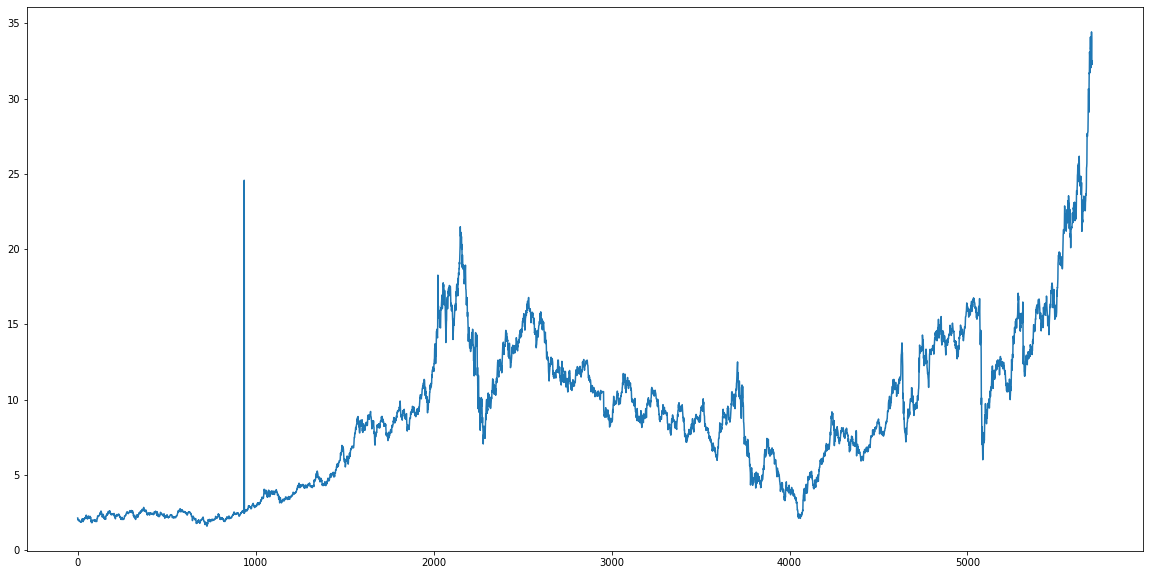

In [ ]:
ts = df_petr4['Open'].interpolate().values
print(kpss_test.should_diff(ts))
print('-'*30)
pd.Series(ts).plot()

### Calculando KPSS para série temporal de Fernando de Noronha

(0.02362582617859753, True)
------------------------------


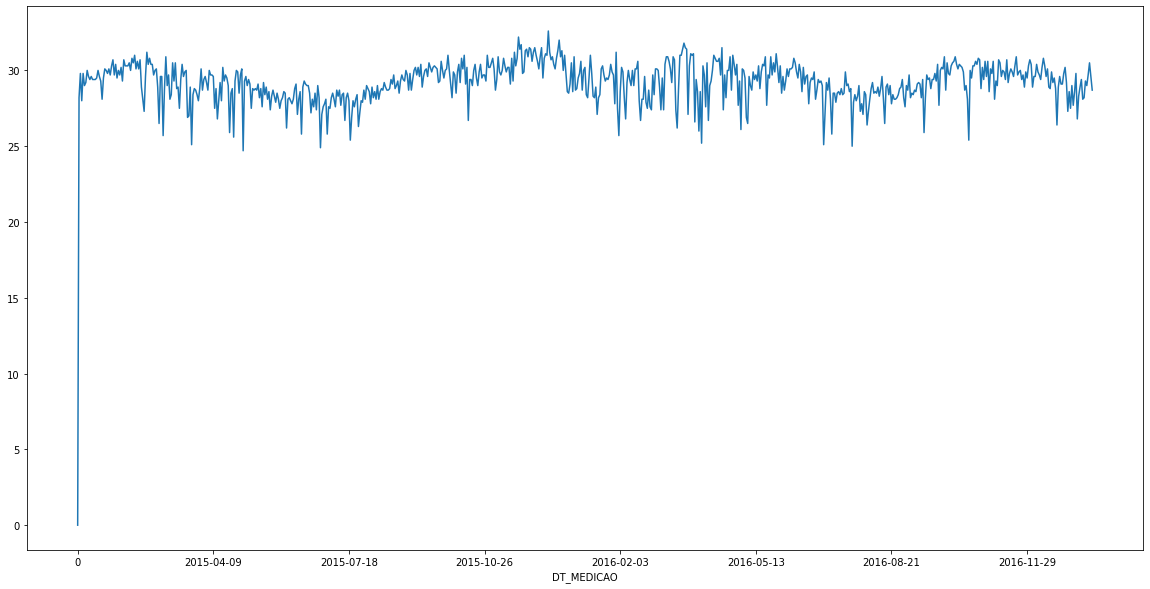

In [ ]:
print(kpss_test.should_diff(noronha_df['TEMP_HORA'].values))
print('-'*30)
noronha_df['TEMP_HORA'].plot()

In [ ]:
print(kpss_test.should_diff(noronha_df))

(0.02362582617859753, True)


# Aplicando Arima e modelos de ML aos nossos datasets

## Aplicando AUTO_ARIMA ao nosso datasert da Petrobras

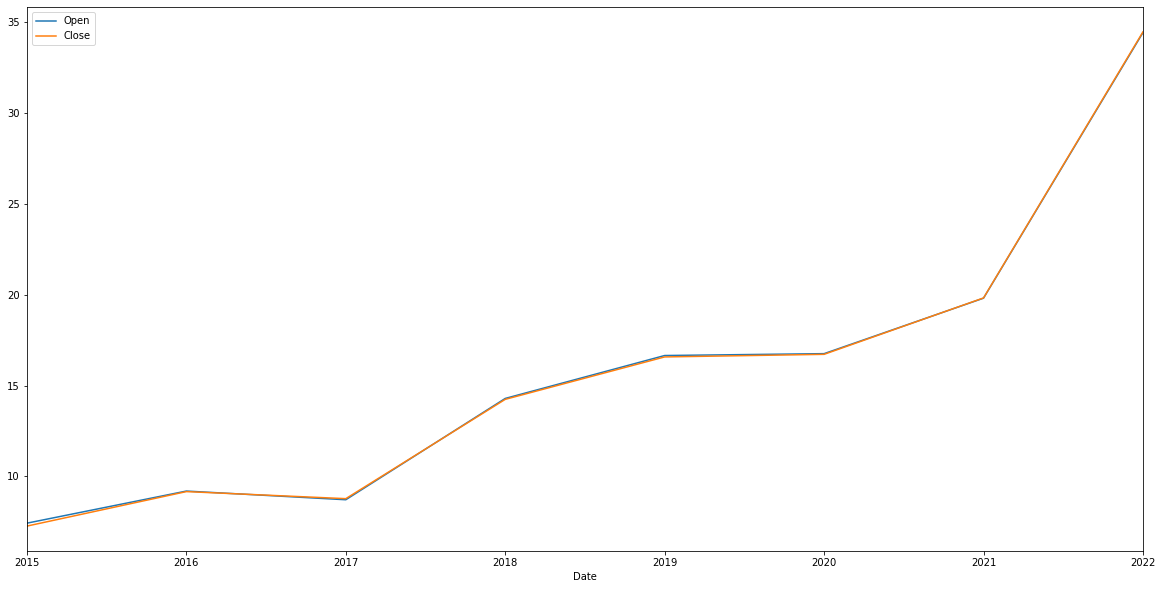

In [ ]:
df_petr4['Close'] = df_petr4['Close'].fillna(0)
df_petr4['Close'].ffill(inplace=True)
df_petr4_plot = df_petr4[['Open','Close']]
max_temp = df_petr4_plot.resample('Y').max().loc['2015-12-31 ':]
max_temp.plot()

In [ ]:
#AUTO ARIMA CLOSE
ts = df_petr4['Close'].interpolate().values
test_size = int(ts.shape[0] * 0.2)

train = ts[0:-test_size]
test = ts[-test_size:]

print(f'Nosso dataset de teste possui: {test.shape[0]} entradas\ne nosso dataset de treino possui {train.shape[0]}.')

Nosso dataset de teste possui: 1140 entradas
e nosso dataset de treino possui 4562.


In [ ]:
model_finance = auto_arima(train, start_p=2,
                          d=None, start_q=2, 
                          max_p=5, max_d=2,
                          max_q=5, start_P=1,
                          D=None, start_Q=1,
                          max_P=2, max_D=1,
                          max_Q=2, max_order=5,
                          m=3, trace=True,
                          maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=-1298.962, Time=6.46 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=-1286.014, Time=0.75 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=-1302.177, Time=2.47 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=-1303.369, Time=3.43 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=-1287.680, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[3] intercept   : AIC=-1285.208, Time=3.06 sec
 ARIMA(0,1,1)(1,0,1)[3] intercept   : AIC=-1303.031, Time=3.66 sec
 ARIMA(0,1,1)(0,0,2)[3] intercept   : AIC=-1304.454, Time=2.68 sec
 ARIMA(0,1,1)(1,0,2)[3] intercept   : AIC=-1304.990, Time=3.15 sec
 ARIMA(0,1,1)(2,0,2)[3] intercept   : AIC=-1302.525, Time=3.76 sec
 ARIMA(0,1,1)(2,0,1)[3] intercept   : AIC=-1304.371, Time=2.53 sec
 ARIMA(0,1,0)(1,0,2)[3] intercept   : AIC=-1305.458, Time=2.37 sec
 ARIMA(0,1,0)(0,0,2)[3] intercept   : AIC=-1304.920, Time=1.96 sec
 ARIMA(0,1,0)(1,0,1)[3] intercept   : AIC=-1303.509, Time=1.53 sec
 ARIMA(0,1,0)(2,0,2

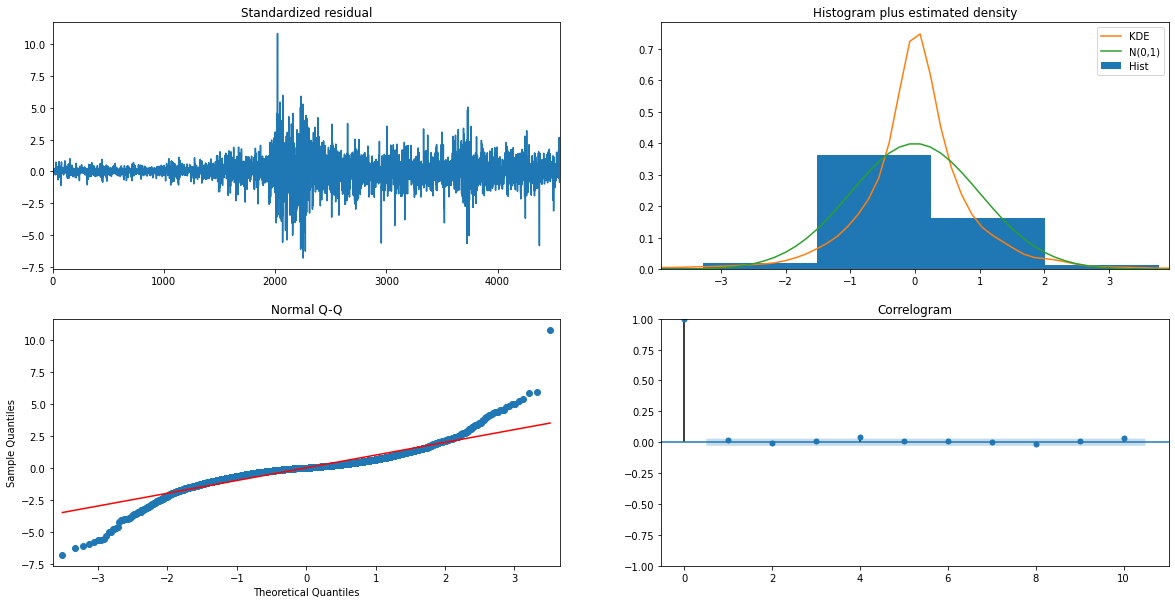

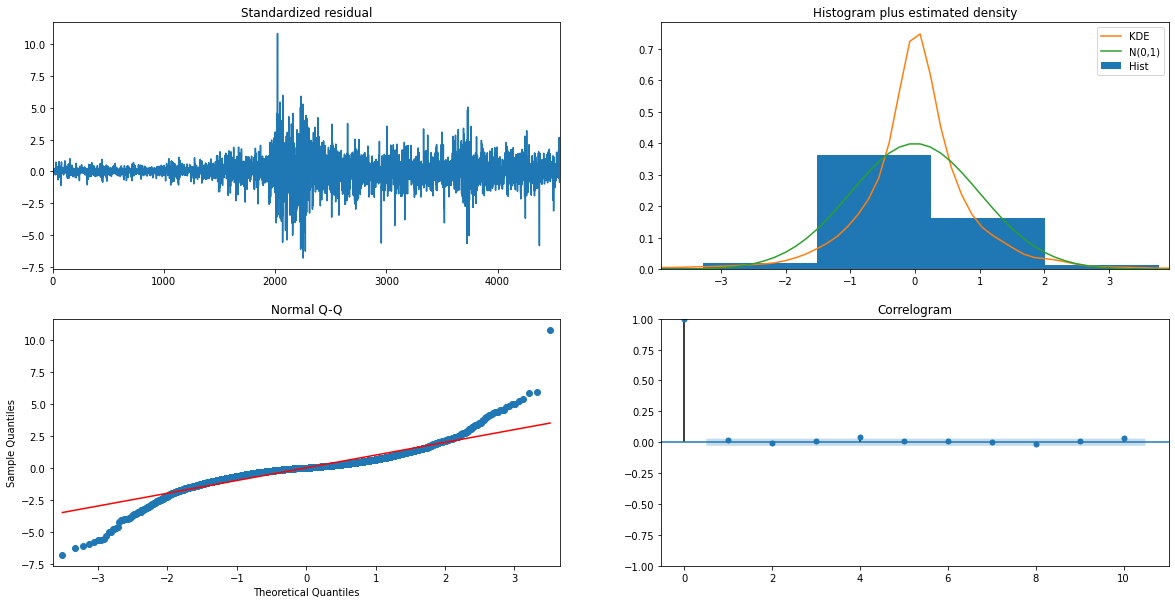

In [ ]:
model_finance.plot_diagnostics()

100%|██████████| 1140/1140 [18:39<00:00,  1.02it/s]


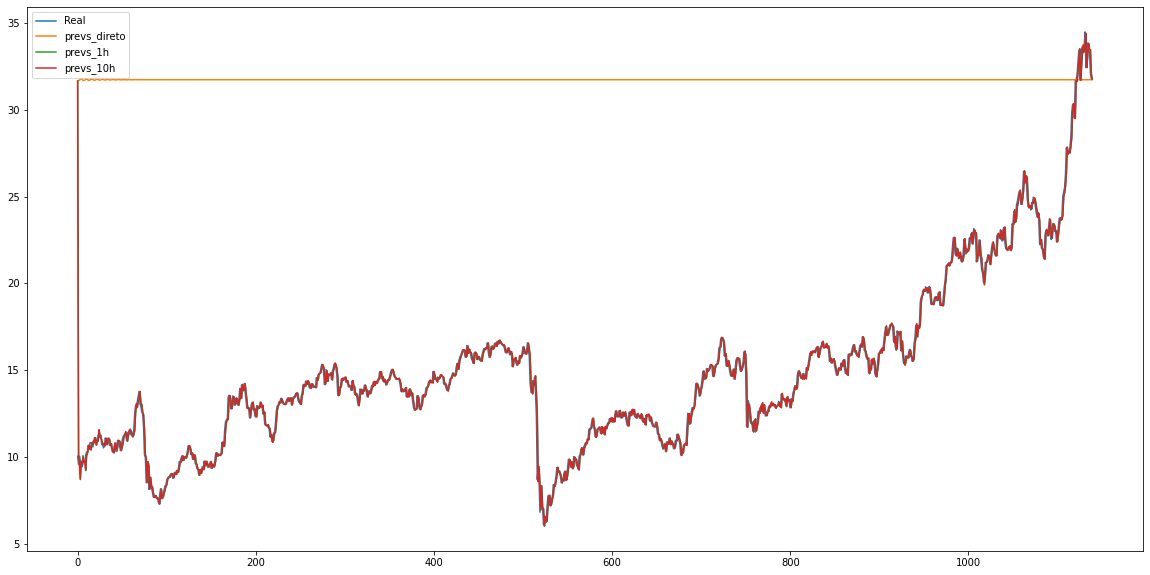

In [ ]:
prevs_direto = model_finance.predict(test_size)


prevs_1h = []
horizon = 1
for t in tqdm(test):
  prevs_1h.append(model_finance.predict(horizon)[horizon-1])
  model_finance.update(t)


prevs_10h = []
horizon = 10
for t in tqdm(test):
  prevs_10h.append(model_finance.predict(horizon)[horizon-10])
  model_finance.update(t)

#Criando dataset para plot de previsões
df_prevs = pd.DataFrame({
    'Real' : test,
    'prevs_direto': prevs_direto,
    'prevs_1h': prevs_1h,
    'prevs_10h': prevs_10h

})

df_prevs.plot()

In [ ]:
#Gerando métricas para lag 1
y_true = df_prevs['Real'].values
y_pred = df_prevs['prevs_1h'].values
gerenerate_metric_results(y_true, y_pred)

{'MSE': 0.585050583224609,
 'MAPE': 2.2544678707388135,
 'MAE': 0.3066286863910093,
 'theil': 0.994701594190324,
 'ARV': 0.025316252617682812,
 'POCID': 49.03508771929825}

In [ ]:
#Gerando métricas para lag 10
y_true = df_prevs['Real'].values
y_pred = df_prevs['prevs_10h'].values
gerenerate_metric_results(y_true, y_pred)

{'MSE': 0.5840148742230323,
 'MAPE': 2.2563863453864497,
 'MAE': 0.30691495083913917,
 'theil': 0.9947723802454157,
 'ARV': 0.02526897165912326,
 'POCID': 49.03508771929825}

Podemos observar que as medidas são parecidas, entre os lags.

In [ ]:
petr_df = pd.DataFrame(df_petr4['Close'].interpolate().values)
lag_size = 1
petr_lagged = create_windowing(petr_df, lag_size)

ts = noronha_df.values
test_size = int(ts.shape[0] * 0.2) #definindo 20% do dataset para teste

X_train = petr_lagged.iloc[0:-test_size].drop(columns=['actual']).values
y_train = petr_lagged.iloc[0:-test_size]['actual'].values
X_test = petr_lagged.iloc[-test_size:].drop(columns=['actual']).values
y_test = petr_lagged.iloc[-test_size:]['actual'].values

In [ ]:
model_svr = svm.SVR()
model_mlp = MLPRegressor()

model_svr.fit(X_train, y_train)

model_mlp.fit(X_train, y_train)

prevs_svr =  model_svr.predict(X_test)
prevs_mlp =  model_mlp.predict(X_test)

In [ ]:
df_prevs = pd.DataFrame()
df_prevs['Real'] = y_test.astype('float')
df_prevs['svr'] = prevs_svr
df_prevs['mlp'] = prevs_mlp
df_prevs

,Real,svr,mlp
0,9.508699,9.404342,9.414657
1,9.564097,9.509219,9.519718
2,9.438189,9.564115,9.574747
3,9.226660,9.439311,9.449677
4,9.569134,9.229319,9.239557
...,...,...,...
2046,33.419998,10.708338,33.273687
2047,33.340000,10.709872,32.857937
2048,32.099998,10.710252,32.780591
2049,31.799999,10.723378,31.581683


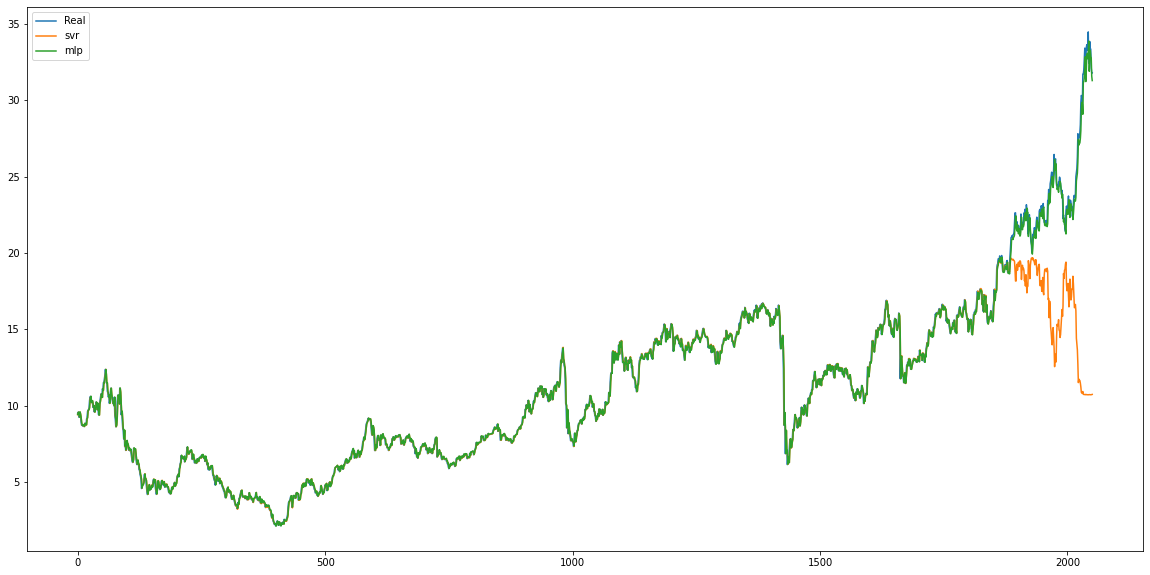

In [ ]:
df_prevs.plot()

Como podemos perceber, na série temporal o MLP acaba perfomando melhor.

O gráfico apresenta uma piora na tendência, sendo influenciado (muito) por eventos passados

In [ ]:
for c in ['svr', 'mlp']:
  y_true = df_prevs['Real']
  y_pred = df_prevs[c]
  print(c)
  print(gerenerate_metric_results(y_true, y_pred))

svr
{'MSE': 8.733334607522288, 'MAPE': 4.532262981689201, 'MAE': 0.831654371925727, 'theil': 75.79528782362455, 'ARV': 0.43476702580973997, 'POCID': 46.70892247684056}
mlp
{'MSE': 0.1268127749087237, 'MAPE': 2.311675857695649, 'MAE': 0.23411058595253606, 'theil': 1.112349394082899, 'ARV': 0.004041875673817914, 'POCID': 47.58654314968308}


## Melhor Avaliação para o SVM

In [ ]:
serie = df_petr4['Close'].interpolate().values

test_size = 200
val_size = 200

forecaster = svm.SVR()

list_params = { "kernel": ['rbf'],
                'gamma': ['scale'],
                'tol':[0.001],
                'C': [10, 50, 100],
                'time_widow': [3, 6, 9, 12]}

list_params = list(ParameterGrid(list_params)) 

svr_results = dispatch(list_params, forecaster, test_size, val_size, serie)

100%|██████████| 12/12 [00:00<00:00, 15.80it/s]

MELHORES PARÂMETROS {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'time_widow': 12, 'tol': 0.001}
MELHOR VALIDAÇÃO 0.0009189129501796769


## Melhor MLP

In [ ]:
serie = df_petr4['Close'].interpolate().values

test_size = 200
val_size = 200

forecaster = MLPRegressor()

list_params = { "hidden_layer_sizes": [10, 30, 50, 100],
               'solver': ['adam', 'sgd', 'lbfgs'],
               'time_widow': [3, 6, 9, 12, 19, 21]}

list_params = list(ParameterGrid(list_params)) 

mlp_results = dispatch(list_params, forecaster, test_size, val_size, serie)

100%|██████████| 72/72 [01:16<00:00,  1.07s/it]

MELHORES PARÂMETROS {'hidden_layer_sizes': 10, 'solver': 'lbfgs', 'time_widow': 3}
MELHOR VALIDAÇÃO 0.00045717364914034506


In [ ]:
gerenerate_metric_results(mlp_results['real'], svr_results['prev'])

{'MSE': 93.99312481761407,
 'MAPE': 29.22774485599878,
 'MAE': 7.546461937053932,
 'theil': 2220.165645946478,
 'ARV': 1.5027857286586639,
 'POCID': 42.5}

In [ ]:
gerenerate_metric_results(mlp_results['real'], mlp_results['prev'])

{'MSE': 0.3606121030781971,
 'MAPE': 1.8561984968202712,
 'MAE': 0.44720983968942657,
 'theil': 1.3738953339421376,
 'ARV': 0.025010950503183048,
 'POCID': 55.50000000000001}

Podemos verificar que nossas métricas estão encaminhando bem para o dataset, nosso POCID não está tão ideal acima de 80, porém há tendência positiva, enquanto nosso MSE apresenta tendência positiva (quanto menos, melhor)

## Aplicando Ensemble no DF Da petrobrás

In [ ]:
serie = df_petr4['Close'].interpolate().values

test_size = 200
val_size = 200

forecaster = MLPRegressor()

list_params = { "hidden_layer_sizes": [10, 12, 15, 22, 30],
               'solver': ['adam', 'lbfgs','sgd'],
               'alpha': [0.0001, 0.001]}

list_params = list(ParameterGrid(list_params)) 

estimator_list =[]
for k in list_params:
  estimator_list.append(clone(forecaster).set_params(**k))

params_bagging = {
    'n_estimators': [10, 50],
    'max_samples': [1, 0.5],
    'max_features': [1, 0.5],
    'base_estimator':estimator_list ,
    'time_widow': [3, 6, 9, 12]
}

list_params_bagging  = list(ParameterGrid(params_bagging)) 

bagg_forecaster = BaggingRegressor()

In [ ]:
bagg_results = dispatch(list_params_bagging, bagg_forecaster, test_size, val_size, serie)

  0%|          | 0/960 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist

MELHORES PARÂMETROS {'base_estimator': MLPRegressor(alpha=0.001, hidden_layer_sizes=10, solver='lbfgs'), 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 10, 'time_widow': 6}
MELHOR VALIDAÇÃO 0.0004772107510545104


## Aplicando Modelos de ML no nosso dataset de Noronha

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

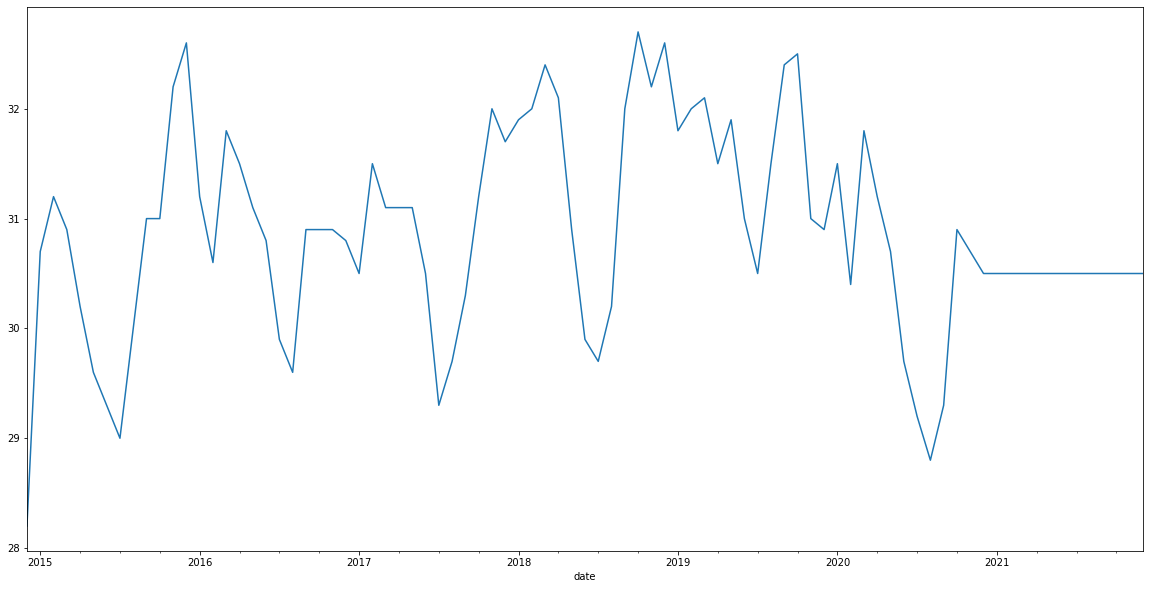

In [ ]:
noronha_df_ = imet_df[['DT_MEDICAO', 'HR_MEDICAO', 'TEMP_HORA']]
noronha_df_['HR_MEDICAO'] = noronha_df_['HR_MEDICAO'].apply(lambda x: str(x).zfill(4))
noronha_df_['date'] = noronha_df_['DT_MEDICAO']+' '+ noronha_df_['HR_MEDICAO']
noronha_df_['date'] = pd.to_datetime(noronha_df_['date'])
noronha_df_ = noronha_df_[['date', 'TEMP_HORA']]
noronha_df_.set_index('date', inplace=True)
noronha_df_.TEMP_HORA.ffill(inplace=True)
noronha_df_ = noronha_df_.fillna(0)
noronha_df_ = (noronha_df_.TEMP_HORA).apply(lambda x: float(x))
max_temp = noronha_df_.resample('M').max()
max_temp.plot()

In [ ]:
ts = noronha_df['TEMP_HORA'].values
test_size = int(ts.shape[0] * 0.1)

train = ts[0:-test_size]
test = ts[-test_size:]

print(f'Nosso dataset de teste possui: {test.shape[0]} entradas\ne nosso dataset de treino possui {train.shape[0]}.')

Nosso dataset de teste possui: 74 entradas
e nosso dataset de treino possui 675.


In [ ]:
model_noronha = auto_arima(train, start_p=2,
                          d=None, start_q=2, 
                          max_p=5, max_d=2,
                          max_q=5, start_P=1,
                          D=None, start_Q=1,
                          max_P=2, max_D=1,
                          max_Q=2, max_order=5,
                          m=3, trace=True,
                          maxiter=100)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=2504.641, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=2638.621, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=2572.237, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=2507.001, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=2637.072, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[3] intercept   : AIC=2502.647, Time=3.15 sec
 ARIMA(2,1,2)(0,0,0)[3] intercept   : AIC=2501.120, Time=3.03 sec
 ARIMA(2,1,2)(1,0,0)[3] intercept   : AIC=2502.660, Time=3.56 sec
 ARIMA(1,1,2)(0,0,0)[3] intercept   : AIC=2500.459, Time=2.47 sec
 ARIMA(1,1,2)(1,0,0)[3] intercept   : AIC=2502.412, Time=1.59 sec
 ARIMA(1,1,2)(0,0,1)[3] intercept   : AIC=2502.409, Time=1.92 sec
 ARIMA(1,1,2)(1,0,1)[3] intercept   : AIC=2504.165, Time=5.24 sec
 ARIMA(0,1,2)(0,0,0)[3] intercept   : AIC=2501.088, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=2501.025, Time=1.52 sec
 ARIMA(0,1,1)(0,0,0)[3] intercept

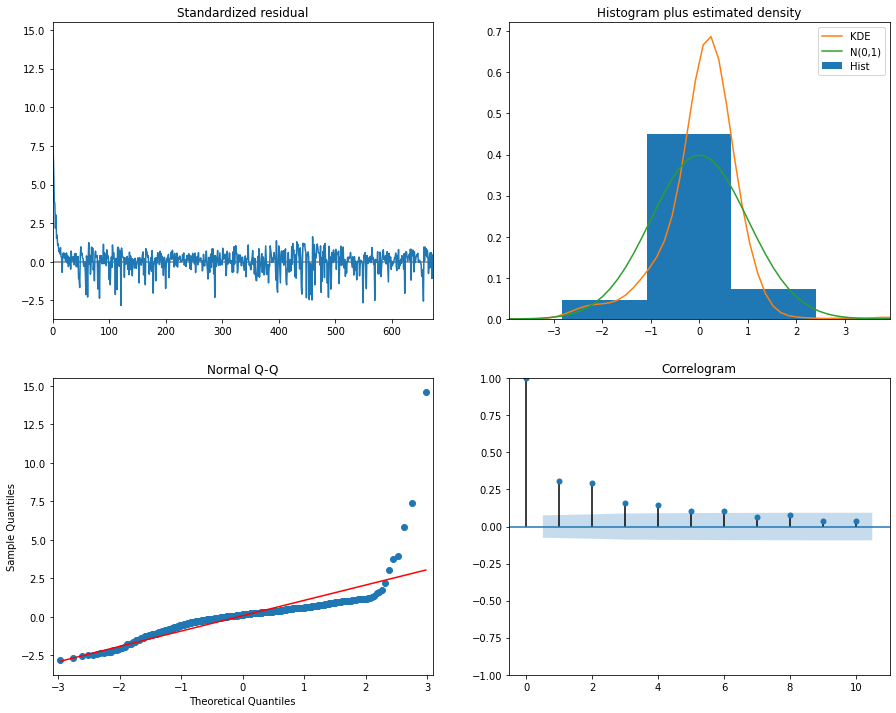

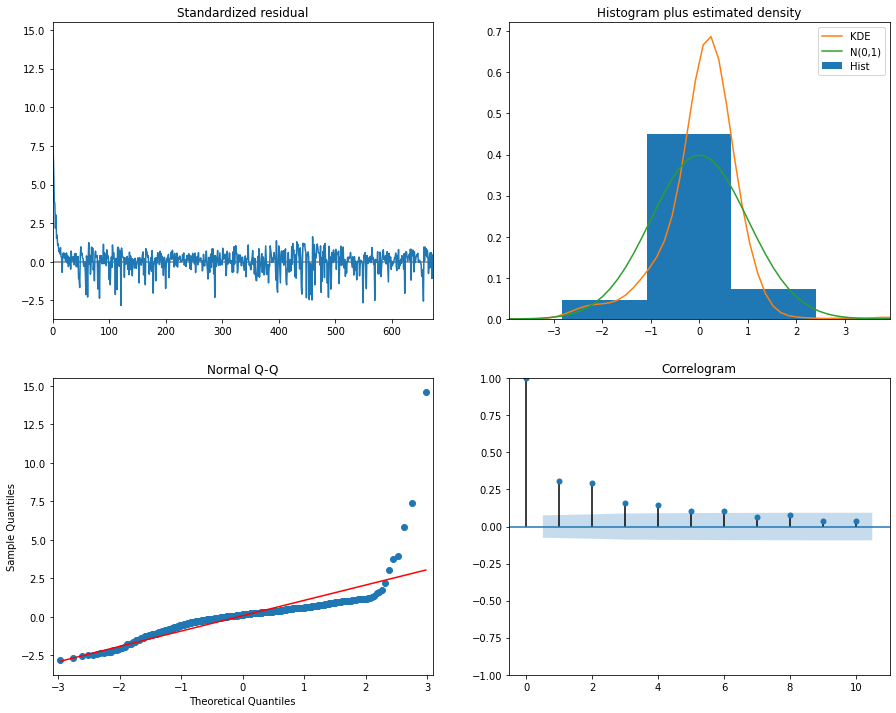

In [ ]:
model_noronha.plot_diagnostics(figsize=(15,12))

100%|██████████| 74/74 [00:13<00:00,  5.33it/s]


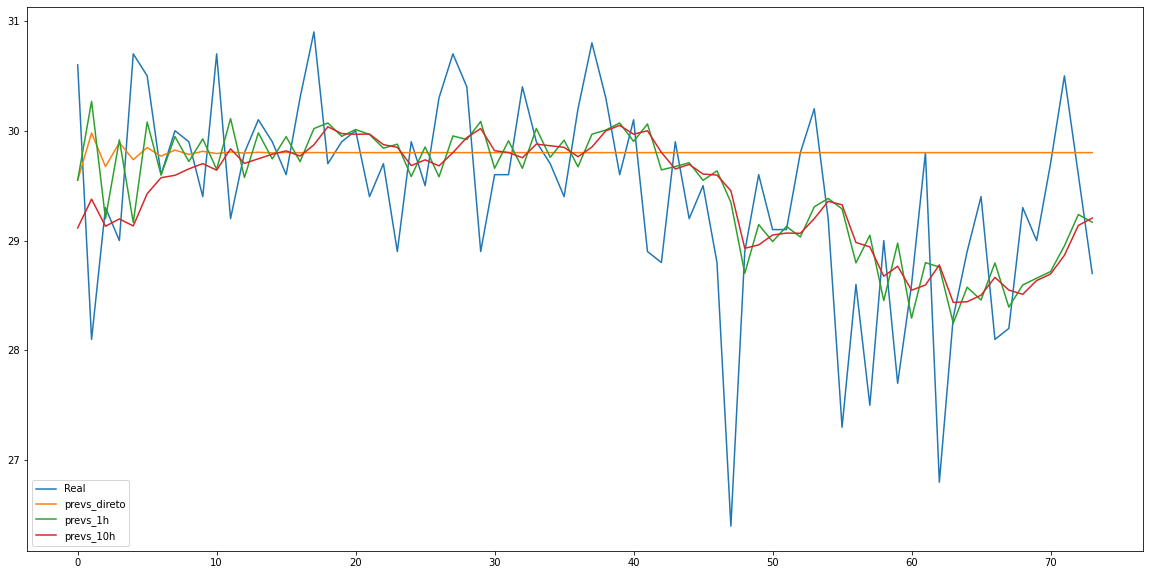

In [ ]:
prevs_direto = model_noronha.predict(test_size)


prevs_1h = []
horizon = 1
for t in tqdm(test):
  prevs_1h.append(model_noronha.predict(horizon)[horizon-1])
  model_noronha.update(t)


prevs_10h = []
horizon = 10
for t in tqdm(test):
  prevs_10h.append(model_noronha.predict(horizon)[horizon-1])
  model_noronha.update(t)

#Criando dataset para plot de previsões
df_prevs = pd.DataFrame({
    'Real' : test,
    'prevs_direto': prevs_direto,
    'prevs_1h': prevs_1h,
    'prevs_10h': prevs_10h

})

df_prevs.plot()

In [ ]:
#Gerando métricas para lag 1
y_true = df_prevs['Real'].values
y_pred = df_prevs['prevs_1h'].values
gerenerate_metric_results(y_true, y_pred)

{'MSE': 0.7015132529374842,
 'MAPE': 2.1391783797730892,
 'MAE': 0.620396746276743,
 'theil': 5.330621538532079,
 'ARV': 2.4392932924373616,
 'POCID': 35.13513513513514}

In [ ]:
#Gerando métricas para lag 10
y_true = df_prevs['Real'].values
y_pred = df_prevs['prevs_10h'].values
gerenerate_metric_results(y_true, y_pred)

{'MSE': 0.6884777446514287,
 'MAPE': 2.1156585869554605,
 'MAE': 0.6151942320139769,
 'theil': 33.129696838080974,
 'ARV': 2.8502311544134895,
 'POCID': 27.027027027027028}

In [ ]:
noronha_df = pd.DataFrame(imet_df['TEMP_HORA'].ffill()).fillna(0)
lag_size = 10
noronha_lagged = create_windowing(noronha_df, lag_size)

ts = noronha_df.values
test_size = int(ts.shape[0] * 0.2) #definindo 20% do dataset para teste

X_train = noronha_lagged.iloc[0:-test_size].drop(columns=['actual']).values
y_train = noronha_lagged.iloc[0:-test_size]['actual'].values
X_test = noronha_lagged.iloc[-test_size:].drop(columns=['actual']).values
y_test = noronha_lagged.iloc[-test_size:]['actual'].values



In [ ]:
from sklearn import svm
from sklearn.neural_network import MLPRegressor

model_svr = svm.SVR()
model_mlp = MLPRegressor()

model_svr.fit(X_train, y_train)

model_mlp.fit(X_train, y_train)

prevs_svr =  model_svr.predict(X_test)
prevs_mlp =  model_mlp.predict(X_test)


<class 'numpy.ndarray'>
[27.29530788 27.6845926  27.47807451 ... 30.24812213 30.24812213
 30.24812213]


In [ ]:
print(type(prevs_svr))
print(type(prevs_mlp))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
df_prevs = pd.DataFrame()
df_prevs['Real'] = y_test.astype('float')
df_prevs['svr'] = prevs_svr
df_prevs['mlp'] = prevs_mlp
df_prevs

,Real,svr,mlp
0,27.6,27.407599,27.295308
1,28.0,27.856175,27.684593
2,27.4,27.600084,27.478075
3,27.4,27.399627,27.249385
4,27.4,27.278149,27.258373
...,...,...,...
2046,30.5,30.554777,30.248122
2047,30.5,30.554777,30.248122
2048,30.5,30.554777,30.248122
2049,30.5,30.554777,30.248122


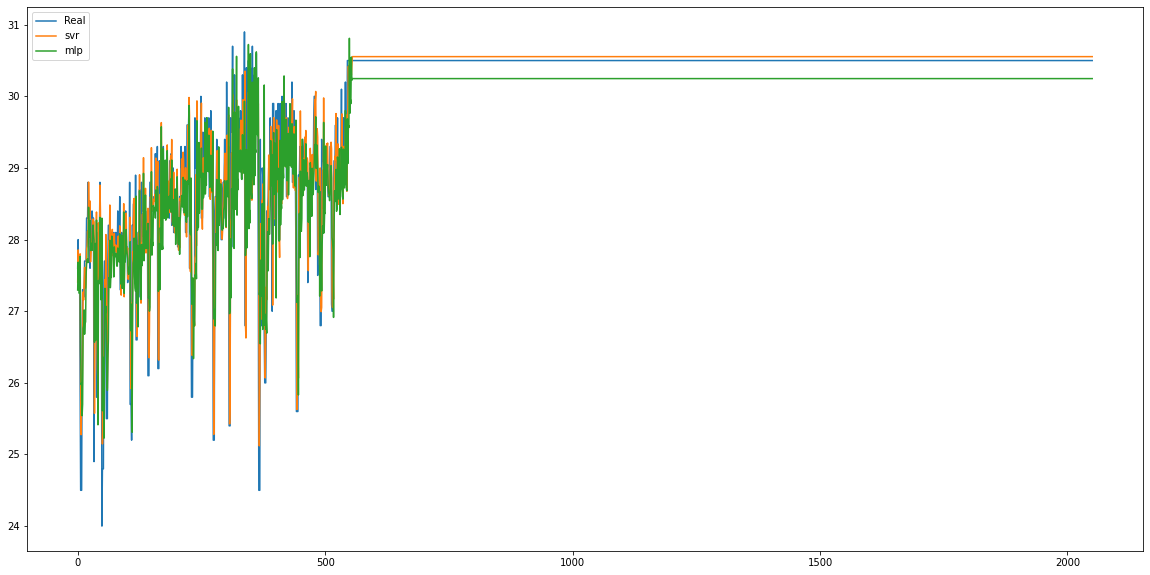

In [ ]:
df_prevs.plot()

Como podemos ver, após certa quantidade de registros, nosso dataset segue uma linearidade, através dele, podemos ver também que o modelo mais adequado é o SVR, devido a sua proximidade com os resultados reais

In [ ]:
for c in ['svr', 'mlp']:
  y_true = df_prevs['Real']
  y_pred = df_prevs[c]
  print(c)
  print(gerenerate_metric_results(y_true, y_pred))

svr
{'MSE': 0.17584389409730394, 'MAPE': 0.6061447433445403, 'MAE': 0.17216963757723394, 'theil': 1.0794513783075026, 'ARV': 0.1516666586957249, 'POCID': 7.069722086786934}
mlp
{'MSE': 0.27656999793393033, 'MAPE': 1.245880434102745, 'MAE': 0.3629078495875626, 'theil': 1.7998746156656171, 'ARV': 0.2686749692319277, 'POCID': 7.996099463676256}


## Melhor avaliação para SVM

In [ ]:
serie = noronha_df['TEMP_HORA'].values

test_size = 200
val_size = 200

forecaster = svm.SVR()

list_params = { "kernel": ['rbf'],
                'gamma': ['scale'],
                'tol':[ 0.001],
                'C': [10, 50, 100],
                'time_widow': [3, 6, 9, 12]}

list_params = list(ParameterGrid(list_params)) 

svr_results = dispatch(list_params, forecaster, test_size, val_size, serie)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  8%|▊         | 1/12 [00:00<00:06,  1.66it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
 17%|█▋        | 2/12 [00:01<00:05,  1.78it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
 25%|██▌       | 3/12 [00:01<00:04,  1.87it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: Run

MELHORES PARÂMETROS {'C': 50, 'gamma': 'scale', 'kernel': 'rbf', 'time_widow': 12, 'tol': 0.001}
MELHOR VALIDAÇÃO 0.0009811827832308054


## Melhor avaliação para MLP

In [ ]:
serie = noronha_df['TEMP_HORA'].values

test_size = 200
val_size = 200

forecaster = MLPRegressor()

list_params = { "hidden_layer_sizes": [10, 30, 50, 100],
               'solver': ['adam', 'sgd', 'lbfgs'],
               'time_widow': [3, 6, 9, 12, 19, 21]}

list_params = list(ParameterGrid(list_params)) 

mlp_results = dispatch(list_params, forecaster, test_size, val_size, serie)

  0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  1%|▏         | 1/72 [00:00<00:46,  1.52it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  3%|▎         | 2/72 [00:01<00:52,  1.34it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  4%|▍         | 3/72 [00:01<00:44,  1.55it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: Run

MELHORES PARÂMETROS {'hidden_layer_sizes': 30, 'solver': 'lbfgs', 'time_widow': 21}
MELHOR VALIDAÇÃO 2.9090386481356427e-07


In [ ]:
gerenerate_metric_results(mlp_results['real'], mlp_results['prev'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


{'MSE': 0.008384132701807575,
 'MAPE': 0.30021281892912116,
 'MAE': 0.09156490977338194,
 'theil': inf,
 'ARV': 1.0,
 'POCID': 0.0}

In [ ]:
gerenerate_metric_results(mlp_results['real'], svr_results['prev'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


{'MSE': 0.9947643409719569,
 'MAPE': 3.270094213019022,
 'MAE': 0.9973787349708019,
 'theil': inf,
 'ARV': 1.0,
 'POCID': 0.0}

## Aplicando Ensemble no DF Noronha

In [ ]:
from sklearn.ensemble import BaggingRegressor


In [ ]:
serie = noronha_df['TEMP_HORA'].values

test_size = 200
val_size = 200

forecaster = MLPRegressor()

list_params = { "hidden_layer_sizes": [10, 12, 15, 22, 30],
               'solver': ['adam', 'lbfgs','sgd'],
               'alpha': [0.0001, 0.001]}

list_params = list(ParameterGrid(list_params)) 

estimator_list =[]
for k in list_params:
  estimator_list.append(clone(forecaster).set_params(**k))

params_bagging = {
    'n_estimators': [10, 50],
    'max_samples': [1, 0.5],
    'max_features': [1, 0.5],
    'base_estimator':estimator_list ,
    'time_widow': [3, 6, 9, 12]
}

list_params_bagging  = list(ParameterGrid(params_bagging)) 

bagg_forecaster = BaggingRegressor()

In [ ]:
bagg_results = dispatch(list_params_bagging, bagg_forecaster, test_size, val_size, serie)

  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-

MELHORES PARÂMETROS {'base_estimator': MLPRegressor(hidden_layer_sizes=10, solver='lbfgs'), 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 10, 'time_widow': 12}
MELHOR VALIDAÇÃO 9.709782485192927e-05


In [ ]:
gerenerate_metric_results(bagg_results['real'], bagg_results['prev'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


{'MSE': 0.1382620774177745,
 'MAPE': 1.219134719509546,
 'MAE': 0.3718360894504116,
 'theil': inf,
 'ARV': 1.0,
 'POCID': 0.0}